In [66]:
import numpy as np
import pandas as pd
import torch

from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.*')

from collections import Counter
from itertools import product

import selfies as sf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

In [2]:
import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

# 1. Loading data

## 1.1 Loading model

In [3]:
folder_path = "../model_results/ZINC250K_vae_property_obj_ws"

config_path = "vae_property_config.pt"
model_path = "vae_property_model_080.pt"

config = torch.load(f"{folder_path}/{config_path}")

vocab_path = "vae_property_vocab.pt"
vocab = torch.load(f"{folder_path}/{vocab_path}")

model = VAEPROPERTY(vocab, config)
model.load_state_dict(torch.load(f"{folder_path}/{model_path}"))



<All keys matched successfully>

## 1.2 Loading train data

In [4]:
data_folder_path = "../moses/dataset/data/ZINC250K"

file_name = "train.csv"

data = pd.read_csv(f"{data_folder_path}/{file_name}")

In [5]:
data.head() #it has smiles, selfies, logP, qed, SAS, obj values

,SMILES,SELFIES,logP,qed,SAS,obj
0,COCCOc1ccc(CNC(=O)c2cnc3ccc(C)cn23)cc1,[C][O][C][C][O][C][=C][C][=C][Branch2][Ring1][...,2.59792,0.672152,2.174005,1.186756
1,Cc1cc(C(=O)NC(C)(C)c2cccc(F)c2)[nH]n1,[C][C][C][=C][Branch2][Ring1][Branch2][C][=Bra...,2.52232,0.891576,2.577987,1.879891
2,CCc1n[nH]c(SCc2nnnn2-c2cc(C)ccc2F)n1,[C][C][C][=N][NH1][C][Branch2][Ring1][=Branch1...,2.08262,0.724791,2.787800,0.836156
3,COc1ccc(CC(=O)Nc2cccc3ncccc23)cc1,[C][O][C][=C][C][=C][Branch2][Ring1][Branch1][...,3.42460,0.801260,1.647545,2.358755
4,CCOc1ccc(Cl)c(C(=O)Nc2cc(C)nn2CCC#N)n1,[C][C][O][C][=C][C][=C][Branch1][C][Cl][C][Bra...,2.80460,0.876945,2.582261,1.802464


### 1.2.1 generate whole_latent_data

In [6]:
np.random.seed(42)
samples = data.iloc[np.random.choice(data.shape[0], 1000, replace=False)]

In [7]:
def get_latent_info(mol_smiles, model):
    mu, log_var, z, _ = model.forward_encoder(model.string2tensor(mol_smiles).reshape(1,-1))

    return mu, log_var, z

In [8]:
def get_latent_whole_info(data, model):
    mu_list = []
    log_var_list = []
    z_list = []
    for i in range(len(data)):
        mu, log_var, z = get_latent_info(data["SMILES"].iloc[i], model)
        mu_list.append(mu)
        log_var_list.append(log_var)
        z_list.append(z)

    mu_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in mu_list], columns=["mu"], index=data.index)
    logvar_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in log_var_list], columns=["logvar"], index=data.index)
    z_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in z_list], columns=["z"], index=data.index)

    return mu_df, logvar_df, z_df

In [9]:
mu_df, log_var_df, z_df = get_latent_whole_info(samples, model)

In [10]:
whole_latent_info = pd.concat([samples, mu_df, log_var_df, z_df], axis=1)

In [11]:
whole_latent_info

,SMILES,SELFIES,logP,qed,SAS,obj,mu,logvar,z
38683,CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2,[C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...,2.55190,0.808834,2.786591,1.257578,"[[0.0006688088, -0.04799132, 0.009349651, 0.00...","[[-0.0018990822, -0.0017098114, 0.0023532398, ...","[[-0.34788042, -1.124217, -1.0180868, 0.110421..."
64939,O=C(CCO)N1CCC2(CC(Nc3ncccn3)CO2)C1,[O][=C][Branch1][Ring2][C][C][O][N][C][C][C][B...,0.03090,0.813958,4.044754,0.025037,"[[-0.00095851347, 0.021082483, 0.007405185, 0....","[[4.9378723e-05, -0.0030402318, 0.0017250776, ...","[[-0.066773355, -0.31944117, 0.28933546, -0.61..."
3954,COc1c(CN(CCC#N)Cc2ccccn2)c(C)nn1C,[C][O][C][=C][Branch2][Ring1][C][C][N][Branch1...,2.04800,0.782484,2.591605,1.320817,"[[0.009314321, 0.0017299056, 0.01059019, -0.00...","[[0.00043804199, -0.0008841902, -0.0006967876,...","[[-0.18035033, 0.8279109, -1.5694437, -1.49101..."
120374,CC(C)CCn1c(=O)c2sccc2n2c(=O)[nH]nc12,[C][C][Branch1][C][C][C][C][N][C][=Branch1][C]...,1.44510,0.787737,2.793158,1.145527,"[[0.0019169301, -0.035416692, 0.0028020684, 0....","[[0.0007841289, -0.0021196902, -0.0014276989, ...","[[-0.6388959, 0.10280505, 0.862791, 1.4218786,..."
172861,N#Cc1ccccc1N1CCN(C(=O)CCN2CCCCC2=O)CC1,[N][#C][C][=C][C][=C][C][=C][Ring1][=Branch1][...,1.60948,0.835036,2.200988,1.974191,"[[0.0012648702, 0.018271655, -0.010631787, 0.0...","[[-0.000246834, -0.0021136627, -0.0008503087, ...","[[-1.4254918, 0.626089, -0.7045371, -0.8695274..."
...,...,...,...,...,...,...,...,...,...
3963,CCOc1ccc(C2NC(=O)NC3=C2C(=O)N(CCC(C)C)C3)cc1,[C][C][O][C][=C][C][=C][Branch2][Ring1][=N][C]...,2.58160,0.833919,2.937811,1.231782,"[[0.0339616, 0.026932195, -0.010883499, 0.0052...","[[0.00015386939, -0.0031673014, -0.0016510524,...","[[-1.81391, -0.26168096, -0.81667995, 0.461852..."
79890,Cc1cc(C)c(NC(=O)CNc2nc3ccccc3nc2C)c(C)c1,[C][C][=C][C][Branch1][C][C][=C][Branch2][Ring...,3.91408,0.758875,2.142944,1.651432,"[[0.024229053, -0.001015991, 0.01246443, 0.001...","[[-0.00049760565, -0.00026541203, -0.000601597...","[[1.4540688, -0.060145635, 0.72156954, 2.17412..."
15295,Cc1cccc(N2CC(C(=O)N3CCOC(C)C3)CC2=O)c1C,[C][C][=C][C][=C][C][Branch2][Ring1][#Branch2]...,1.90364,0.837225,2.955786,1.230338,"[[0.0052305683, 0.016977385, -0.02318297, -0.0...","[[-0.0023915023, -0.0017191097, -0.0006081946,...","[[-0.8468702, 0.38266927, -0.011780726, -0.366..."
218373,CN(Cc1cccnc1)S(=O)(=O)N1CCNCC1,[C][N][Branch1][#Branch2][C][C][=C][C][=C][N][...,-0.33660,0.812984,2.360259,1.704662,"[[-0.008896768, 0.05477962, -0.019030368, 0.02...","[[0.0043442287, -0.005062647, -0.00561619, 0.0...","[[0.09740945, 1.4767339, 0.62416536, -2.151724..."


## 1.2.2 for test mol, generate molecular diagram

In [81]:
props = ["logP", "qed", "SAS", "obj"]

for idx, prop in enumerate(props):
    print(idx,prop)

0 logP
1 qed
2 SAS
3 obj


In [97]:
def sample_latent_space(mu, model, ranges=(3,3), latent_dim=128, n_trials=1000, 
                        n_grid=6, temp=0.01, orthogonal_vec=(None,None), save_name=None, prop_save_name=None,
                        props=None): #note : props should be list of properties among "logP", "qed", "SA", "obj

    np.random.seed(42)

    if orthogonal_vec[0] is None or orthogonal_vec[1] is None: # orthogonal vectors are not given -> set two basis vectors
        orthogonal_vec = np.eye(latent_dim)[np.random.randint(0, latent_dim, 2)]

    x_range, y_range = ranges

    dx = np.linspace(-x_range, x_range, 2*n_grid+1)
    dy = np.linspace(-y_range, y_range, 2*n_grid+1)

    grid = pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1))

    prop_grid_list = []

    for _ in range(len(props)):
        prop_grid_list.append(pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1)))

    for i_x, i_y in tqdm(product(range(2*n_grid+1), range(2*n_grid+1)), desc='whole_iters', total=(2*n_grid+1)**2): #each data points
        z_point = mu + dx[i_x]*orthogonal_vec[0] + dy[i_y]*orthogonal_vec[1] # move the point to the direction of the unit vector
        most_freq_mol, freq_df = decode_z(z_point, model, n_trials, temp)

        grid.iloc[i_x, i_y] = most_freq_mol

        for idx, prop in enumerate(props):
            prop_grid_list[idx].iloc[i_x, i_y] = calc_avg_prop(freq_df, props=prop)
    
    if save_name is not None:
        grid.to_csv(save_name)
    
    if prop_save_name is not None:
        for idx, prop in enumerate(props):
            prop_grid_list[idx].to_csv(f"{prop_save_name}_{prop}.csv")
    
    return grid

def decode_z(z, model, n_trials, temp):
    # decode n_trials times from z using the model sample function, and pick most frequent one
    z_input = torch.tensor(z).repeat(n_trials).reshape(n_trials, -1)

    z_input = z_input.float()

    decoded_mols = model.sample(n_batch=z_input.shape[0], z=z_input, temp=temp)

    valid_decoded_mols = [Chem.MolFromSmiles(mol) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]
    
    print(f"ratio of valid molecules : {len(valid_decoded_mols)}/{n_trials}")

    canon_dec_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(mol), canonical=True) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]

    mol_freq = Counter(canon_dec_mols)

    most_freq_mol, _ = find_argmax(mol_freq)

    freq_df = get_mol_freq(mol_freq)

    return most_freq_mol, freq_df

def find_argmax(counter):
    # Get the most common element and its count
    most_common_element = counter.most_common(1)
    if most_common_element:
        element, count = most_common_element[0]
        return element, count
    else:
        return None, None

def get_mol_freq(counter):
    # Get the most common element and its count
    mols = counter.keys()
    counts = counter.values()

    freq_df = pd.DataFrame({"mols":mols, "counts":counts})

    return freq_df

def calc_avg_prop(freq_df, props=None):
    if props is None:
        return None
    
    mols = freq_df["mols"] # smiles
    counts = freq_df["counts"]

    avg_prop = 0
    total_count = 0

    for mol, count in zip(mols, counts):
        prop = get_mol_prop(mol, props) # if mol is invalid, skip that molecule and exclude from the calculation of average property.

        if prop is not None:
            total_count += count
            avg_prop += prop*count

    avg_prop /= total_count

    return avg_prop

def get_mol_prop(mol, props): # get the property of the molecule
    chemmol = Chem.MolFromSmiles(mol)

    if chemmol is None:
        return None

    if props == "logP":
        return logP(chemmol)
    elif props == "qed":
        return QED(chemmol)
    elif props == "SA":
        return SA(chemmol)
    elif props == 'obj':
        return 5 * QED(chemmol) - SA(chemmol)
    else:
        return None
    
def plot_freq_mols_with_color(freq_mols_grid_df):
    # TODO : implement using category and color
    raise NotImplementedError

def plot_freq_mols(freq_mols_grid_info, save_name=None):
    if type(freq_mols_grid_info) is str:
        plot_prop_mols_from_path(freq_mols_grid_info, save_name)
    elif type(freq_mols_grid_info) is pd.DataFrame:
        plot_prop_mols_from_df(freq_mols_grid_info, save_name)
    else:
        raise ValueError("Invalid input type")

def plot_freq_mols_from_path(freq_grid_path, save_name=None):
    freq_mols_grid = pd.read_csv(freq_grid_path, index_col=0)

    plot_freq_mols_from_df(freq_mols_grid, save_name)

def plot_freq_mols_from_df(freq_mols_grid, save_name=None):
    n_rows, n_cols = freq_mols_grid.shape

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))

    for i in range(n_rows):
        for j in range(n_cols):
            mol = Chem.MolFromSmiles(freq_mols_grid.iloc[i,j])
            if mol is not None:
                img = Chem.Draw.MolToImage(mol, size=(300,300))
                ax[i,j].imshow(img)
                ax[i,j].axis("off")
            else:
                ax[i,j].axis("off")

    if save_name is not None:
        plt.savefig(save_name, dpi=300)
        plt.clf()

def plot_prop_mols(prop_grid_info, save_name=None, prop_name=None):
    if type(prop_grid_info) is str:
        plot_prop_mols_from_path(prop_grid_info, save_name, prop_name)
    elif type(prop_grid_info) is pd.DataFrame:
        plot_prop_mols_from_df(prop_grid_info, save_name, prop_name)
    else:
        raise ValueError("Invalid input type")
    
def plot_prop_mols_from_path(prop_grid_path, save_name=None, prop_name=None):
    prop_grid = pd.read_csv(prop_grid_path, index_col=0)

    plot_prop_mols_from_df(prop_grid, save_name, prop_name)

        
def plot_prop_mols_from_df(prop_df, save_name=None, prop_name=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = prop_df.index
    y = np.arange(len(prop_df.columns))

    X,Y = np.meshgrid(x,y)

    Z = prop_df.values

    print(prop_df)
    print(x)
    print(y)
    print(Z)

    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)


    ax.set_title("property surface in subspace of latent space")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel(prop_name)

    if save_name is not None:
        plt.savefig(save_name, dpi=300)
        plt.clf()

In [116]:
def stack_df(prop_df_path):
    prop_df = pd.read_csv(prop_df_path, index_col=0)

    x = prop_df.index
    y = np.arange(len(prop_df.columns))

    stacked_df = pd.DataFrame(columns=["x", "y", "prop"], index=range(len(x)*len(y)))

    for i in range(len(x)):
        for j in range(len(y)):
            stacked_df.iloc[i*len(y)+j] = [(x[i]-10), y[j]-10, prop_df.iloc[i,j]]

    return stacked_df

In [117]:
prop = "obj"
path = f"../notebooks/figures/two_other_orthogonal_basis/csv_folder/test_mol_prop_0.csv_{prop}.csv"

stacked_df = stack_df(path)

In [118]:
stacked_df.to_csv(f"{prop}.csv")

In [14]:
test_mol = whole_latent_info.iloc[0]

In [15]:
test_mol

SMILES                       CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2
SELFIES    [C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...
logP                                                  2.5519
qed                                                 0.808834
SAS                                                 2.786591
obj                                                 1.257578
mu         [[0.0006688088, -0.04799132, 0.009349651, 0.00...
logvar     [[-0.0018990822, -0.0017098114, 0.0023532398, ...
z          [[-0.34788042, -1.124217, -1.0180868, 0.110421...
Name: 38683, dtype: object

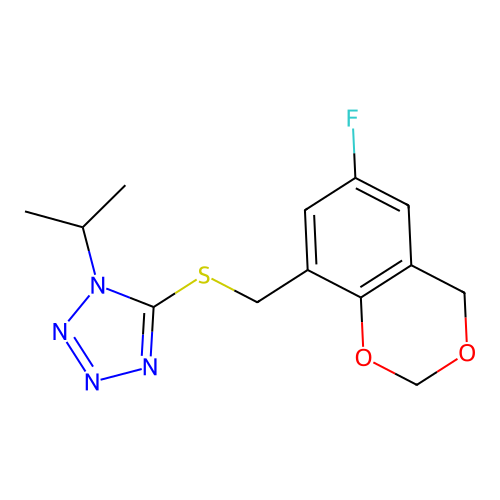

In [16]:
img = Chem.Draw.MolToImage(Chem.MolFromSmiles(test_mol['SMILES']), size=(500,500))


img

In [96]:
for prop in ["logP", "SA", "qed", "obj"]:
        plot_prop_mols(prop_grid_info=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv_{prop}.csv", save_name=f"{save_folder_path}/{prop_fname}_{i}_{prop}.png")

           0         1         2         3         4         5         6  \
0   4.070800  4.021334  3.297052  2.834140  2.834140  2.834140  2.834140   
1   4.070800  2.821651  2.834140  2.834140  2.834140  2.834140  3.301843   
2   2.209700  2.834140  2.834140  2.834140  2.834140  2.900386  3.275204   
3   2.834140  2.834140  2.834140  2.834140  2.170338  3.097134  3.318852   
4   2.834140  2.834140  2.834140  2.124046  2.971718  3.236042  3.361200   
5   2.508553  2.725826  1.303208  2.642566  3.947800  3.686954  3.356930   
6   1.390560  1.096430  2.104670  2.865974  4.283154  4.230036  3.288732   
7   1.028900  1.526708  2.365770  3.434846  3.846260  3.318788  3.263820   
8   1.465480  2.492132  2.949666  3.316636  3.287400  3.594368  3.555030   
9   3.988460  4.169040  3.576832  3.504204  3.502690  3.572448  3.381796   
10  4.488896  4.447060  3.625396  3.600132  3.534624  3.600132  3.393450   
11  4.544500  4.459460  3.655500  3.655500  3.617676  3.603090  3.341040   
12  1.714478

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [95]:
ranges_list = [(30,30)]

temp_list = [0.01]

experiments = list(product(ranges_list, temp_list))

v1 = np.ones(config.d_z)
v1 = v1/np.linalg.norm(v1) # 1/sqrt(128)*np.ones(128)

v2 = np.array([1 if i < config.d_z//2 else -1 for i in range(config.d_z)])
v2 = v2/np.linalg.norm(v2) # 1/sqrt(128)*[1,1,1,1,1...,-1(65th coord),-1,-1,-1,-1... -1]

save_folder_path = "figures/two_other_orthogonal_basis"
prop_fname = "test_mol_prop"
mol_fname = "test_mol"

for i, (ranges, temp) in enumerate(experiments):
    print(f"------------- Experiment {i} -------------")
    
    grid = sample_latent_space(test_mol["mu"][0], model, ranges=ranges, temp=temp, n_trials=50, n_grid=10, orthogonal_vec=(v1,v2),
                               prop_save_name=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv", props=["logP", "SA", "qed", "obj"],
                               save_name=f"{save_folder_path}/csv_folder/{mol_fname}_{i}.csv")
    
    plot_freq_mols(grid, save_name=f"{save_folder_path}/{mol_fname}_{i}.png")

    for prop in ["logP", "SA", "qed", "obj"]:
        plot_prop_mols(prop_grid_info=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv_{prop}.csv", save_name=f"{save_folder_path}/{prop_fname}_{i}_{prop}.png")

------------- Experiment 0 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 50/50


whole_iters:   0%|          | 2/441 [00:01<03:32,  2.07it/s]

ratio of valid molecules : 50/50


whole_iters:   1%|          | 3/441 [00:01<03:10,  2.30it/s]

ratio of valid molecules : 50/50


whole_iters:   1%|          | 4/441 [00:01<02:56,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:   1%|          | 5/441 [00:02<02:50,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:   1%|▏         | 6/441 [00:02<02:52,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:   2%|▏         | 7/441 [00:02<02:46,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:   2%|▏         | 8/441 [00:03<02:46,  2.61it/s]

ratio of valid molecules : 50/50


whole_iters:   2%|▏         | 9/441 [00:03<02:42,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:   2%|▏         | 10/441 [00:04<02:45,  2.61it/s]

ratio of valid molecules : 50/50


whole_iters:   2%|▏         | 11/441 [00:04<02:50,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:   3%|▎         | 12/441 [00:04<02:50,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:   3%|▎         | 13/441 [00:05<02:45,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:   3%|▎         | 14/441 [00:05<02:42,  2.62it/s]

ratio of valid molecules : 50/50


whole_iters:   3%|▎         | 15/441 [00:05<02:40,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:   4%|▎         | 16/441 [00:06<02:39,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:   4%|▍         | 17/441 [00:06<02:40,  2.64it/s]

ratio of valid molecules : 50/50


whole_iters:   4%|▍         | 18/441 [00:07<02:39,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:   4%|▍         | 19/441 [00:07<02:40,  2.63it/s]

ratio of valid molecules : 50/50


whole_iters:   5%|▍         | 20/441 [00:07<02:41,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:   5%|▍         | 21/441 [00:08<02:44,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:   5%|▍         | 22/441 [00:08<02:42,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:   5%|▌         | 23/441 [00:09<02:41,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:   5%|▌         | 24/441 [00:09<02:46,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:   6%|▌         | 25/441 [00:09<02:43,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:   6%|▌         | 26/441 [00:10<02:48,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:   6%|▌         | 27/441 [00:10<02:52,  2.40it/s]

ratio of valid molecules : 50/50


whole_iters:   6%|▋         | 28/441 [00:11<03:01,  2.27it/s]

ratio of valid molecules : 50/50


whole_iters:   7%|▋         | 29/441 [00:11<03:03,  2.25it/s]

ratio of valid molecules : 50/50


whole_iters:   7%|▋         | 30/441 [00:12<03:00,  2.27it/s]

ratio of valid molecules : 50/50


whole_iters:   7%|▋         | 31/441 [00:12<02:59,  2.28it/s]

ratio of valid molecules : 50/50


whole_iters:   7%|▋         | 32/441 [00:12<03:02,  2.25it/s]

ratio of valid molecules : 50/50


whole_iters:   7%|▋         | 33/441 [00:13<02:58,  2.28it/s]

ratio of valid molecules : 50/50


whole_iters:   8%|▊         | 34/441 [00:13<02:57,  2.29it/s]

ratio of valid molecules : 50/50


whole_iters:   8%|▊         | 35/441 [00:14<02:54,  2.32it/s]

ratio of valid molecules : 50/50


whole_iters:   8%|▊         | 36/441 [00:14<02:49,  2.39it/s]

ratio of valid molecules : 50/50


whole_iters:   8%|▊         | 37/441 [00:15<02:49,  2.38it/s]

ratio of valid molecules : 50/50


whole_iters:   9%|▊         | 38/441 [00:15<02:46,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:   9%|▉         | 39/441 [00:15<02:45,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:   9%|▉         | 40/441 [00:16<02:49,  2.36it/s]

ratio of valid molecules : 50/50


whole_iters:   9%|▉         | 41/441 [00:16<02:50,  2.35it/s]

ratio of valid molecules : 50/50


whole_iters:  10%|▉         | 42/441 [00:17<02:46,  2.39it/s]

ratio of valid molecules : 50/50


whole_iters:  10%|▉         | 43/441 [00:17<02:43,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  10%|▉         | 44/441 [00:17<02:40,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  10%|█         | 45/441 [00:18<02:36,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  10%|█         | 46/441 [00:18<02:34,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  11%|█         | 47/441 [00:19<02:36,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  11%|█         | 48/441 [00:19<02:36,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  11%|█         | 49/441 [00:19<02:35,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  11%|█▏        | 50/441 [00:20<02:35,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  12%|█▏        | 51/441 [00:20<02:36,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  12%|█▏        | 52/441 [00:21<02:34,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  12%|█▏        | 53/441 [00:21<02:36,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  12%|█▏        | 54/441 [00:21<02:35,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  12%|█▏        | 55/441 [00:22<02:35,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  13%|█▎        | 56/441 [00:22<02:37,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  13%|█▎        | 57/441 [00:23<02:42,  2.37it/s]

ratio of valid molecules : 50/50


whole_iters:  13%|█▎        | 58/441 [00:23<02:39,  2.39it/s]

ratio of valid molecules : 50/50


whole_iters:  13%|█▎        | 59/441 [00:24<02:38,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  14%|█▎        | 60/441 [00:24<02:39,  2.39it/s]

ratio of valid molecules : 50/50


whole_iters:  14%|█▍        | 61/441 [00:24<02:40,  2.37it/s]

ratio of valid molecules : 50/50


whole_iters:  14%|█▍        | 62/441 [00:25<02:32,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  14%|█▍        | 63/441 [00:25<02:26,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  15%|█▍        | 64/441 [00:26<02:29,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  15%|█▍        | 65/441 [00:26<02:32,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  15%|█▍        | 66/441 [00:26<02:33,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  15%|█▌        | 67/441 [00:27<02:32,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  15%|█▌        | 68/441 [00:27<02:33,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  16%|█▌        | 69/441 [00:28<02:33,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  16%|█▌        | 70/441 [00:28<02:31,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  16%|█▌        | 71/441 [00:28<02:30,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  16%|█▋        | 72/441 [00:29<02:32,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  17%|█▋        | 73/441 [00:29<02:35,  2.37it/s]

ratio of valid molecules : 50/50


whole_iters:  17%|█▋        | 74/441 [00:30<02:35,  2.36it/s]

ratio of valid molecules : 50/50


whole_iters:  17%|█▋        | 75/441 [00:30<02:34,  2.37it/s]

ratio of valid molecules : 50/50


whole_iters:  17%|█▋        | 76/441 [00:30<02:31,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  17%|█▋        | 77/441 [00:31<02:28,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  18%|█▊        | 78/441 [00:31<02:24,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  18%|█▊        | 79/441 [00:32<02:23,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  18%|█▊        | 80/441 [00:32<02:21,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  18%|█▊        | 81/441 [00:32<02:22,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  19%|█▊        | 82/441 [00:33<02:22,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  19%|█▉        | 83/441 [00:33<02:20,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  19%|█▉        | 84/441 [00:34<02:19,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  19%|█▉        | 85/441 [00:34<02:19,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  20%|█▉        | 86/441 [00:34<02:17,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  20%|█▉        | 87/441 [00:35<02:17,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  20%|█▉        | 88/441 [00:35<02:18,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  20%|██        | 89/441 [00:36<02:22,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  20%|██        | 90/441 [00:36<02:23,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  21%|██        | 91/441 [00:36<02:24,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  21%|██        | 92/441 [00:37<02:21,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  21%|██        | 93/441 [00:37<02:19,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  21%|██▏       | 94/441 [00:38<02:18,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  22%|██▏       | 95/441 [00:38<02:18,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  22%|██▏       | 96/441 [00:38<02:19,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  22%|██▏       | 97/441 [00:39<02:19,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  22%|██▏       | 98/441 [00:39<02:19,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  22%|██▏       | 99/441 [00:40<02:17,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  23%|██▎       | 100/441 [00:40<02:14,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  23%|██▎       | 101/441 [00:40<02:15,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  23%|██▎       | 102/441 [00:41<02:15,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  23%|██▎       | 103/441 [00:41<02:14,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  24%|██▎       | 104/441 [00:42<02:11,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  24%|██▍       | 105/441 [00:42<02:11,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  24%|██▍       | 106/441 [00:42<02:10,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  24%|██▍       | 107/441 [00:43<02:11,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  24%|██▍       | 108/441 [00:43<02:12,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  25%|██▍       | 109/441 [00:44<02:12,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  25%|██▍       | 110/441 [00:44<02:12,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  25%|██▌       | 111/441 [00:44<02:16,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  25%|██▌       | 112/441 [00:45<02:15,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  26%|██▌       | 113/441 [00:45<02:12,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  26%|██▌       | 114/441 [00:46<02:11,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  26%|██▌       | 115/441 [00:46<02:11,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  26%|██▋       | 116/441 [00:46<02:10,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  27%|██▋       | 117/441 [00:47<02:12,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  27%|██▋       | 118/441 [00:47<02:12,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  27%|██▋       | 119/441 [00:48<02:12,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  27%|██▋       | 120/441 [00:48<02:11,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  27%|██▋       | 121/441 [00:49<02:11,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  28%|██▊       | 122/441 [00:49<02:09,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  28%|██▊       | 123/441 [00:49<02:07,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  28%|██▊       | 124/441 [00:50<02:06,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  28%|██▊       | 125/441 [00:50<02:09,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  29%|██▊       | 126/441 [00:51<02:06,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  29%|██▉       | 127/441 [00:51<02:05,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  29%|██▉       | 128/441 [00:51<02:03,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  29%|██▉       | 129/441 [00:52<02:02,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  29%|██▉       | 130/441 [00:52<02:02,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  30%|██▉       | 131/441 [00:53<02:07,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  30%|██▉       | 132/441 [00:53<02:07,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  30%|███       | 133/441 [00:53<02:08,  2.40it/s]

ratio of valid molecules : 50/50


whole_iters:  30%|███       | 134/441 [00:54<02:07,  2.40it/s]

ratio of valid molecules : 50/50


whole_iters:  31%|███       | 135/441 [00:54<02:06,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  31%|███       | 136/441 [00:55<02:04,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  31%|███       | 137/441 [00:55<02:04,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  31%|███▏      | 138/441 [00:55<02:03,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  32%|███▏      | 139/441 [00:56<02:05,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  32%|███▏      | 140/441 [00:56<02:07,  2.36it/s]

ratio of valid molecules : 50/50


whole_iters:  32%|███▏      | 141/441 [00:57<02:05,  2.38it/s]

ratio of valid molecules : 50/50


whole_iters:  32%|███▏      | 142/441 [00:57<02:04,  2.40it/s]

ratio of valid molecules : 50/50


whole_iters:  32%|███▏      | 143/441 [00:58<02:03,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  33%|███▎      | 144/441 [00:58<02:01,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  33%|███▎      | 145/441 [00:58<02:00,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  33%|███▎      | 146/441 [00:59<01:58,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  33%|███▎      | 147/441 [00:59<01:56,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  34%|███▎      | 148/441 [00:59<01:53,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  34%|███▍      | 149/441 [01:00<01:53,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  34%|███▍      | 150/441 [01:00<01:56,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  34%|███▍      | 151/441 [01:01<01:57,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  34%|███▍      | 152/441 [01:01<02:00,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  35%|███▍      | 153/441 [01:02<01:59,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  35%|███▍      | 154/441 [01:02<01:58,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  35%|███▌      | 155/441 [01:02<01:58,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  35%|███▌      | 156/441 [01:03<01:57,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  36%|███▌      | 157/441 [01:03<01:58,  2.40it/s]

ratio of valid molecules : 50/50


whole_iters:  36%|███▌      | 158/441 [01:04<01:59,  2.38it/s]

ratio of valid molecules : 50/50


whole_iters:  36%|███▌      | 159/441 [01:04<01:59,  2.36it/s]

ratio of valid molecules : 50/50


whole_iters:  36%|███▋      | 160/441 [01:04<01:58,  2.37it/s]

ratio of valid molecules : 50/50


whole_iters:  37%|███▋      | 161/441 [01:05<01:55,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  37%|███▋      | 162/441 [01:05<01:54,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  37%|███▋      | 163/441 [01:06<01:53,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  37%|███▋      | 164/441 [01:06<01:53,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  37%|███▋      | 165/441 [01:06<01:50,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  38%|███▊      | 166/441 [01:07<01:49,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  38%|███▊      | 167/441 [01:07<01:49,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  38%|███▊      | 168/441 [01:08<01:48,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  38%|███▊      | 169/441 [01:08<01:50,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  39%|███▊      | 170/441 [01:09<01:50,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  39%|███▉      | 171/441 [01:09<01:50,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  39%|███▉      | 172/441 [01:09<01:53,  2.37it/s]

ratio of valid molecules : 50/50


whole_iters:  39%|███▉      | 173/441 [01:10<01:51,  2.39it/s]

ratio of valid molecules : 50/50


whole_iters:  39%|███▉      | 174/441 [01:10<01:48,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  40%|███▉      | 175/441 [01:11<01:47,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  40%|███▉      | 176/441 [01:11<01:45,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  40%|████      | 177/441 [01:11<01:45,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  40%|████      | 178/441 [01:12<01:46,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  41%|████      | 179/441 [01:12<01:45,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  41%|████      | 180/441 [01:13<01:46,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  41%|████      | 181/441 [01:13<01:45,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  41%|████▏     | 182/441 [01:13<01:45,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  41%|████▏     | 183/441 [01:14<01:44,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  42%|████▏     | 184/441 [01:14<01:43,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  42%|████▏     | 185/441 [01:15<01:42,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  42%|████▏     | 186/441 [01:15<01:42,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  42%|████▏     | 187/441 [01:15<01:42,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  43%|████▎     | 188/441 [01:16<01:40,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  43%|████▎     | 189/441 [01:16<01:40,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  43%|████▎     | 190/441 [01:17<01:39,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  43%|████▎     | 191/441 [01:17<01:38,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  44%|████▎     | 192/441 [01:17<01:39,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  44%|████▍     | 193/441 [01:18<01:37,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  44%|████▍     | 194/441 [01:18<01:37,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  44%|████▍     | 195/441 [01:19<01:35,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  44%|████▍     | 196/441 [01:19<01:37,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  45%|████▍     | 197/441 [01:19<01:35,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  45%|████▍     | 198/441 [01:20<01:34,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  45%|████▌     | 199/441 [01:20<01:33,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  45%|████▌     | 200/441 [01:20<01:33,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  46%|████▌     | 201/441 [01:21<01:35,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  46%|████▌     | 202/441 [01:21<01:35,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  46%|████▌     | 203/441 [01:22<01:36,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  46%|████▋     | 204/441 [01:22<01:35,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  46%|████▋     | 205/441 [01:23<01:37,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  47%|████▋     | 206/441 [01:23<01:36,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  47%|████▋     | 207/441 [01:23<01:36,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  47%|████▋     | 208/441 [01:24<01:36,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  47%|████▋     | 209/441 [01:24<01:35,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  48%|████▊     | 210/441 [01:25<01:35,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  48%|████▊     | 211/441 [01:25<01:33,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  48%|████▊     | 212/441 [01:25<01:33,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  48%|████▊     | 213/441 [01:26<01:32,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  49%|████▊     | 214/441 [01:26<01:33,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  49%|████▉     | 215/441 [01:27<01:32,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  49%|████▉     | 216/441 [01:27<01:30,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  49%|████▉     | 217/441 [01:27<01:29,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  49%|████▉     | 218/441 [01:28<01:28,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  50%|████▉     | 219/441 [01:28<01:28,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  50%|████▉     | 220/441 [01:29<01:28,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  50%|█████     | 221/441 [01:29<01:28,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  50%|█████     | 222/441 [01:29<01:29,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  51%|█████     | 223/441 [01:30<01:30,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  51%|█████     | 224/441 [01:30<01:29,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  51%|█████     | 225/441 [01:31<01:29,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  51%|█████     | 226/441 [01:31<01:28,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  51%|█████▏    | 227/441 [01:32<01:27,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  52%|█████▏    | 228/441 [01:32<01:26,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  52%|█████▏    | 229/441 [01:32<01:26,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  52%|█████▏    | 230/441 [01:33<01:26,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  52%|█████▏    | 231/441 [01:33<01:25,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  53%|█████▎    | 232/441 [01:34<01:25,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  53%|█████▎    | 233/441 [01:34<01:24,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  53%|█████▎    | 234/441 [01:34<01:23,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  53%|█████▎    | 235/441 [01:35<01:22,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  54%|█████▎    | 236/441 [01:35<01:21,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  54%|█████▎    | 237/441 [01:36<01:21,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  54%|█████▍    | 238/441 [01:36<01:20,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  54%|█████▍    | 239/441 [01:36<01:19,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  54%|█████▍    | 240/441 [01:37<01:19,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  55%|█████▍    | 241/441 [01:37<01:20,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  55%|█████▍    | 242/441 [01:38<01:19,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  55%|█████▌    | 243/441 [01:38<01:19,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  55%|█████▌    | 244/441 [01:38<01:20,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  56%|█████▌    | 245/441 [01:39<01:19,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  56%|█████▌    | 246/441 [01:39<01:19,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  56%|█████▌    | 247/441 [01:40<01:18,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  56%|█████▌    | 248/441 [01:40<01:18,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  56%|█████▋    | 249/441 [01:40<01:17,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  57%|█████▋    | 250/441 [01:41<01:19,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  57%|█████▋    | 251/441 [01:41<01:18,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  57%|█████▋    | 252/441 [01:42<01:16,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  57%|█████▋    | 253/441 [01:42<01:15,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  58%|█████▊    | 254/441 [01:42<01:14,  2.51it/s]

ratio of valid molecules : 50/50


whole_iters:  58%|█████▊    | 255/441 [01:43<01:12,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  58%|█████▊    | 256/441 [01:43<01:11,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  58%|█████▊    | 257/441 [01:44<01:10,  2.62it/s]

ratio of valid molecules : 50/50


whole_iters:  59%|█████▊    | 258/441 [01:44<01:09,  2.64it/s]

ratio of valid molecules : 50/50


whole_iters:  59%|█████▊    | 259/441 [01:44<01:08,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  59%|█████▉    | 260/441 [01:45<01:08,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  59%|█████▉    | 261/441 [01:45<01:07,  2.67it/s]

ratio of valid molecules : 50/50


whole_iters:  59%|█████▉    | 262/441 [01:45<01:08,  2.62it/s]

ratio of valid molecules : 50/50


whole_iters:  60%|█████▉    | 263/441 [01:46<01:07,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  60%|█████▉    | 264/441 [01:46<01:07,  2.61it/s]

ratio of valid molecules : 50/50


whole_iters:  60%|██████    | 265/441 [01:47<01:09,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  60%|██████    | 266/441 [01:47<01:08,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  61%|██████    | 267/441 [01:47<01:07,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  61%|██████    | 268/441 [01:48<01:07,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  61%|██████    | 269/441 [01:48<01:06,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  61%|██████    | 270/441 [01:49<01:05,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:  61%|██████▏   | 271/441 [01:49<01:06,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  62%|██████▏   | 272/441 [01:49<01:06,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  62%|██████▏   | 273/441 [01:50<01:06,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  62%|██████▏   | 274/441 [01:50<01:05,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  62%|██████▏   | 275/441 [01:51<01:05,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  63%|██████▎   | 276/441 [01:51<01:04,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  63%|██████▎   | 277/441 [01:51<01:02,  2.61it/s]

ratio of valid molecules : 50/50


whole_iters:  63%|██████▎   | 278/441 [01:52<01:01,  2.64it/s]

ratio of valid molecules : 50/50


whole_iters:  63%|██████▎   | 279/441 [01:52<01:01,  2.64it/s]

ratio of valid molecules : 50/50


whole_iters:  63%|██████▎   | 280/441 [01:52<01:00,  2.68it/s]

ratio of valid molecules : 50/50


whole_iters:  64%|██████▎   | 281/441 [01:53<00:59,  2.67it/s]

ratio of valid molecules : 50/50


whole_iters:  64%|██████▍   | 282/441 [01:53<00:59,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:  64%|██████▍   | 283/441 [01:54<00:59,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:  64%|██████▍   | 284/441 [01:54<00:59,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  65%|██████▍   | 285/441 [01:54<01:00,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:  65%|██████▍   | 286/441 [01:55<01:00,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  65%|██████▌   | 287/441 [01:55<01:00,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  65%|██████▌   | 288/441 [01:55<00:59,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  66%|██████▌   | 289/441 [01:56<00:58,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  66%|██████▌   | 290/441 [01:56<00:58,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  66%|██████▌   | 291/441 [01:57<00:57,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  66%|██████▌   | 292/441 [01:57<00:57,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:  66%|██████▋   | 293/441 [01:57<00:57,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  67%|██████▋   | 294/441 [01:58<00:56,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  67%|██████▋   | 295/441 [01:58<00:56,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  67%|██████▋   | 296/441 [01:59<00:55,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  67%|██████▋   | 297/441 [01:59<00:55,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  68%|██████▊   | 298/441 [01:59<00:54,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  68%|██████▊   | 299/441 [02:00<00:54,  2.62it/s]

ratio of valid molecules : 50/50


whole_iters:  68%|██████▊   | 300/441 [02:00<00:53,  2.63it/s]

ratio of valid molecules : 50/50


whole_iters:  68%|██████▊   | 301/441 [02:00<00:52,  2.64it/s]

ratio of valid molecules : 50/50


whole_iters:  68%|██████▊   | 302/441 [02:01<00:52,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:  69%|██████▊   | 303/441 [02:01<00:51,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:  69%|██████▉   | 304/441 [02:02<00:51,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  69%|██████▉   | 305/441 [02:02<00:51,  2.64it/s]

ratio of valid molecules : 50/50


whole_iters:  69%|██████▉   | 306/441 [02:02<00:51,  2.62it/s]

ratio of valid molecules : 50/50


whole_iters:  70%|██████▉   | 307/441 [02:03<00:52,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  70%|██████▉   | 308/441 [02:03<00:52,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  70%|███████   | 309/441 [02:04<00:51,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  70%|███████   | 310/441 [02:04<00:51,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  71%|███████   | 311/441 [02:04<00:50,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  71%|███████   | 312/441 [02:05<00:49,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:  71%|███████   | 313/441 [02:05<00:50,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  71%|███████   | 314/441 [02:06<00:49,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  71%|███████▏  | 315/441 [02:06<00:49,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  72%|███████▏  | 316/441 [02:06<00:48,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:  72%|███████▏  | 317/441 [02:07<00:47,  2.61it/s]

ratio of valid molecules : 50/50


whole_iters:  72%|███████▏  | 318/441 [02:07<00:47,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  72%|███████▏  | 319/441 [02:07<00:47,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  73%|███████▎  | 320/441 [02:08<00:46,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  73%|███████▎  | 321/441 [02:08<00:46,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  73%|███████▎  | 322/441 [02:09<00:45,  2.63it/s]

ratio of valid molecules : 50/50


whole_iters:  73%|███████▎  | 323/441 [02:09<00:44,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  73%|███████▎  | 324/441 [02:09<00:43,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:  74%|███████▎  | 325/441 [02:10<00:43,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  74%|███████▍  | 326/441 [02:10<00:43,  2.62it/s]

ratio of valid molecules : 50/50


whole_iters:  74%|███████▍  | 327/441 [02:10<00:43,  2.64it/s]

ratio of valid molecules : 50/50


whole_iters:  74%|███████▍  | 328/441 [02:11<00:43,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:  75%|███████▍  | 329/441 [02:11<00:43,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  75%|███████▍  | 330/441 [02:12<00:43,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  75%|███████▌  | 331/441 [02:12<00:42,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  75%|███████▌  | 332/441 [02:12<00:42,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  76%|███████▌  | 333/441 [02:13<00:41,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:  76%|███████▌  | 334/441 [02:13<00:41,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  76%|███████▌  | 335/441 [02:14<00:41,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  76%|███████▌  | 336/441 [02:14<00:40,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  76%|███████▋  | 337/441 [02:14<00:40,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  77%|███████▋  | 338/441 [02:15<00:39,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  77%|███████▋  | 339/441 [02:15<00:39,  2.61it/s]

ratio of valid molecules : 50/50


whole_iters:  77%|███████▋  | 340/441 [02:16<00:39,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  77%|███████▋  | 341/441 [02:16<00:39,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  78%|███████▊  | 342/441 [02:16<00:38,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  78%|███████▊  | 343/441 [02:17<00:37,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  78%|███████▊  | 344/441 [02:17<00:36,  2.63it/s]

ratio of valid molecules : 50/50


whole_iters:  78%|███████▊  | 345/441 [02:17<00:36,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  78%|███████▊  | 346/441 [02:18<00:35,  2.64it/s]

ratio of valid molecules : 50/50


whole_iters:  79%|███████▊  | 347/441 [02:18<00:35,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  79%|███████▉  | 348/441 [02:19<00:35,  2.61it/s]

ratio of valid molecules : 50/50


whole_iters:  79%|███████▉  | 349/441 [02:19<00:35,  2.59it/s]

ratio of valid molecules : 50/50


whole_iters:  79%|███████▉  | 350/441 [02:19<00:35,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  80%|███████▉  | 351/441 [02:20<00:35,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  80%|███████▉  | 352/441 [02:20<00:34,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  80%|████████  | 353/441 [02:21<00:34,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  80%|████████  | 354/441 [02:21<00:33,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  80%|████████  | 355/441 [02:21<00:32,  2.61it/s]

ratio of valid molecules : 50/50


whole_iters:  81%|████████  | 356/441 [02:22<00:32,  2.62it/s]

ratio of valid molecules : 50/50


whole_iters:  81%|████████  | 357/441 [02:22<00:32,  2.60it/s]

ratio of valid molecules : 50/50


whole_iters:  81%|████████  | 358/441 [02:22<00:32,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  81%|████████▏ | 359/441 [02:23<00:31,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  82%|████████▏ | 360/441 [02:23<00:31,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  82%|████████▏ | 361/441 [02:24<00:31,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  82%|████████▏ | 362/441 [02:24<00:31,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  82%|████████▏ | 363/441 [02:24<00:32,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters:  83%|████████▎ | 364/441 [02:25<00:31,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  83%|████████▎ | 365/441 [02:25<00:31,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  83%|████████▎ | 366/441 [02:26<00:30,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  83%|████████▎ | 367/441 [02:26<00:30,  2.40it/s]

ratio of valid molecules : 50/50


whole_iters:  83%|████████▎ | 368/441 [02:27<00:31,  2.31it/s]

ratio of valid molecules : 50/50


whole_iters:  84%|████████▎ | 369/441 [02:27<00:31,  2.29it/s]

ratio of valid molecules : 50/50


whole_iters:  84%|████████▍ | 370/441 [02:28<00:31,  2.23it/s]

ratio of valid molecules : 50/50


whole_iters:  84%|████████▍ | 371/441 [02:28<00:31,  2.20it/s]

ratio of valid molecules : 50/50


whole_iters:  84%|████████▍ | 372/441 [02:28<00:31,  2.19it/s]

ratio of valid molecules : 50/50


whole_iters:  85%|████████▍ | 373/441 [02:29<00:30,  2.22it/s]

ratio of valid molecules : 50/50


whole_iters:  85%|████████▍ | 374/441 [02:29<00:30,  2.22it/s]

ratio of valid molecules : 50/50


whole_iters:  85%|████████▌ | 375/441 [02:30<00:29,  2.22it/s]

ratio of valid molecules : 50/50


whole_iters:  85%|████████▌ | 376/441 [02:30<00:28,  2.30it/s]

ratio of valid molecules : 50/50


whole_iters:  85%|████████▌ | 377/441 [02:31<00:27,  2.36it/s]

ratio of valid molecules : 50/50


whole_iters:  86%|████████▌ | 378/441 [02:31<00:26,  2.36it/s]

ratio of valid molecules : 50/50


whole_iters:  86%|████████▌ | 379/441 [02:31<00:26,  2.32it/s]

ratio of valid molecules : 50/50


whole_iters:  86%|████████▌ | 380/441 [02:32<00:26,  2.32it/s]

ratio of valid molecules : 50/50


whole_iters:  86%|████████▋ | 381/441 [02:32<00:25,  2.31it/s]

ratio of valid molecules : 50/50


whole_iters:  87%|████████▋ | 382/441 [02:33<00:25,  2.28it/s]

ratio of valid molecules : 50/50


whole_iters:  87%|████████▋ | 383/441 [02:33<00:25,  2.28it/s]

ratio of valid molecules : 50/50


whole_iters:  87%|████████▋ | 384/441 [02:34<00:24,  2.29it/s]

ratio of valid molecules : 50/50


whole_iters:  87%|████████▋ | 385/441 [02:34<00:24,  2.29it/s]

ratio of valid molecules : 50/50


whole_iters:  88%|████████▊ | 386/441 [02:35<00:23,  2.29it/s]

ratio of valid molecules : 50/50


whole_iters:  88%|████████▊ | 387/441 [02:35<00:23,  2.31it/s]

ratio of valid molecules : 50/50


whole_iters:  88%|████████▊ | 388/441 [02:35<00:23,  2.30it/s]

ratio of valid molecules : 50/50


whole_iters:  88%|████████▊ | 389/441 [02:36<00:22,  2.27it/s]

ratio of valid molecules : 50/50


whole_iters:  88%|████████▊ | 390/441 [02:36<00:22,  2.24it/s]

ratio of valid molecules : 50/50


whole_iters:  89%|████████▊ | 391/441 [02:37<00:21,  2.32it/s]

ratio of valid molecules : 50/50


whole_iters:  89%|████████▉ | 392/441 [02:37<00:21,  2.33it/s]

ratio of valid molecules : 50/50


whole_iters:  89%|████████▉ | 393/441 [02:38<00:20,  2.37it/s]

ratio of valid molecules : 50/50


whole_iters:  89%|████████▉ | 394/441 [02:38<00:20,  2.33it/s]

ratio of valid molecules : 50/50


whole_iters:  90%|████████▉ | 395/441 [02:38<00:19,  2.36it/s]

ratio of valid molecules : 50/50


whole_iters:  90%|████████▉ | 396/441 [02:39<00:18,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  90%|█████████ | 397/441 [02:39<00:17,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  90%|█████████ | 398/441 [02:40<00:16,  2.55it/s]

ratio of valid molecules : 50/50


whole_iters:  90%|█████████ | 399/441 [02:40<00:16,  2.53it/s]

ratio of valid molecules : 50/50


whole_iters:  91%|█████████ | 400/441 [02:40<00:16,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  91%|█████████ | 401/441 [02:41<00:16,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  91%|█████████ | 402/441 [02:41<00:15,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  91%|█████████▏| 403/441 [02:42<00:15,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  92%|█████████▏| 404/441 [02:42<00:15,  2.44it/s]

ratio of valid molecules : 50/50


whole_iters:  92%|█████████▏| 405/441 [02:42<00:14,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  92%|█████████▏| 406/441 [02:43<00:14,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  92%|█████████▏| 407/441 [02:43<00:13,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  93%|█████████▎| 408/441 [02:44<00:13,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  93%|█████████▎| 409/441 [02:44<00:12,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  93%|█████████▎| 410/441 [02:44<00:12,  2.57it/s]

ratio of valid molecules : 50/50


whole_iters:  93%|█████████▎| 411/441 [02:45<00:11,  2.62it/s]

ratio of valid molecules : 50/50


whole_iters:  93%|█████████▎| 412/441 [02:45<00:10,  2.66it/s]

ratio of valid molecules : 50/50


whole_iters:  94%|█████████▎| 413/441 [02:45<00:10,  2.68it/s]

ratio of valid molecules : 50/50


whole_iters:  94%|█████████▍| 414/441 [02:46<00:10,  2.65it/s]

ratio of valid molecules : 50/50


whole_iters:  94%|█████████▍| 415/441 [02:46<00:10,  2.56it/s]

ratio of valid molecules : 50/50


whole_iters:  94%|█████████▍| 416/441 [02:47<00:09,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  95%|█████████▍| 417/441 [02:47<00:09,  2.54it/s]

ratio of valid molecules : 50/50


whole_iters:  95%|█████████▍| 418/441 [02:47<00:09,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  95%|█████████▌| 419/441 [02:48<00:08,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  95%|█████████▌| 420/441 [02:48<00:08,  2.47it/s]

ratio of valid molecules : 50/50


whole_iters:  95%|█████████▌| 421/441 [02:49<00:08,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  96%|█████████▌| 422/441 [02:49<00:07,  2.45it/s]

ratio of valid molecules : 50/50


whole_iters:  96%|█████████▌| 423/441 [02:50<00:07,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  96%|█████████▌| 424/441 [02:50<00:06,  2.50it/s]

ratio of valid molecules : 50/50


whole_iters:  96%|█████████▋| 425/441 [02:50<00:06,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  97%|█████████▋| 426/441 [02:51<00:05,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  97%|█████████▋| 427/441 [02:51<00:06,  2.32it/s]

ratio of valid molecules : 50/50


whole_iters:  97%|█████████▋| 428/441 [02:52<00:05,  2.35it/s]

ratio of valid molecules : 50/50


whole_iters:  97%|█████████▋| 429/441 [02:52<00:04,  2.43it/s]

ratio of valid molecules : 50/50


whole_iters:  98%|█████████▊| 430/441 [02:52<00:04,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  98%|█████████▊| 431/441 [02:53<00:03,  2.52it/s]

ratio of valid molecules : 50/50


whole_iters:  98%|█████████▊| 432/441 [02:53<00:03,  2.58it/s]

ratio of valid molecules : 50/50


whole_iters:  98%|█████████▊| 433/441 [02:54<00:03,  2.49it/s]

ratio of valid molecules : 50/50


whole_iters:  98%|█████████▊| 434/441 [02:54<00:02,  2.46it/s]

ratio of valid molecules : 50/50


whole_iters:  99%|█████████▊| 435/441 [02:54<00:02,  2.48it/s]

ratio of valid molecules : 50/50


whole_iters:  99%|█████████▉| 436/441 [02:55<00:02,  2.39it/s]

ratio of valid molecules : 50/50


whole_iters:  99%|█████████▉| 437/441 [02:55<00:01,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters:  99%|█████████▉| 438/441 [02:56<00:01,  2.42it/s]

ratio of valid molecules : 50/50


whole_iters: 100%|█████████▉| 439/441 [02:56<00:00,  2.41it/s]

ratio of valid molecules : 50/50


whole_iters: 100%|█████████▉| 440/441 [02:56<00:00,  2.40it/s]

ratio of valid molecules : 50/50


whole_iters: 100%|██████████| 441/441 [02:57<00:00,  2.49it/s]

ratio of valid molecules : 50/50


FileNotFoundError: [Errno 2] No such file or directory: 'figures/two_other_orthogonal_basis/csv_folder/test_mol_prop_0.csv'

<Figure size 1000x1000 with 0 Axes>

## Above code is for testing, the below one is for real plotting

In [64]:
ranges_list = [(10,10), (20,20), (30,30)]

temp_list = [0.01, 0.1, 1]

experiments = list(product(ranges_list, temp_list))

v1 = np.ones(config.d_z)
v1 = v1/np.linalg.norm(v1) # 1/sqrt(128)*np.ones(128)

v2 = np.array([1 if i < config.d_z//2 else -1 for i in range(config.d_z)])
v2 = v2/np.linalg.norm(v2) # 1/sqrt(128)*[1,1,1,1,1...,-1(65th coord),-1,-1,-1,-1... -1]

save_folder_path = "figures/two_other_orthogonal_basis"

for i, (ranges, temp) in enumerate(experiments):
    print(f"------------- Experiment {i} -------------")
    
    grid = sample_latent_space(test_mol["mu"][0], model, ranges=ranges, temp=temp, n_trials=1000, n_grid=10, orthogonal_vec=(v1,v2),
                               prop_save_name=f"{save_folder_path}/test_mol_prop_{i}.csv", props="logP",
                               save_name=f"{save_folder_path}/test_mol_{i}.csv")
    plot_freq_mols(grid, save_name=f"{save_folder_path}/test_mol_{i}.png")

------------- Experiment 0 -------------


whole_iters:   1%|          | 1/121 [00:00<00:53,  2.26it/s]

ratio of valid molecules : 10/10


whole_iters:   2%|▏         | 2/121 [00:00<00:56,  2.12it/s]

ratio of valid molecules : 10/10


whole_iters:   2%|▏         | 3/121 [00:01<00:56,  2.10it/s]

ratio of valid molecules : 10/10


whole_iters:   3%|▎         | 4/121 [00:01<00:56,  2.07it/s]

ratio of valid molecules : 10/10


whole_iters:   4%|▍         | 5/121 [00:02<00:55,  2.08it/s]

ratio of valid molecules : 10/10


whole_iters:   5%|▍         | 6/121 [00:02<00:54,  2.09it/s]

ratio of valid molecules : 10/10


whole_iters:   6%|▌         | 7/121 [00:03<00:51,  2.22it/s]

ratio of valid molecules : 10/10


whole_iters:   7%|▋         | 8/121 [00:03<00:50,  2.22it/s]

ratio of valid molecules : 10/10


whole_iters:   7%|▋         | 9/121 [00:04<00:48,  2.32it/s]

ratio of valid molecules : 10/10


whole_iters:   8%|▊         | 10/121 [00:04<00:45,  2.41it/s]

ratio of valid molecules : 10/10


whole_iters:   9%|▉         | 11/121 [00:04<00:44,  2.48it/s]

ratio of valid molecules : 10/10


whole_iters:  10%|▉         | 12/121 [00:05<00:43,  2.53it/s]

ratio of valid molecules : 10/10


whole_iters:  11%|█         | 13/121 [00:05<00:42,  2.54it/s]

ratio of valid molecules : 10/10


whole_iters:  12%|█▏        | 14/121 [00:05<00:41,  2.57it/s]

ratio of valid molecules : 10/10


whole_iters:  12%|█▏        | 15/121 [00:06<00:40,  2.59it/s]

ratio of valid molecules : 10/10


whole_iters:  13%|█▎        | 16/121 [00:06<00:42,  2.46it/s]

ratio of valid molecules : 10/10


whole_iters:  14%|█▍        | 17/121 [00:07<00:42,  2.45it/s]

ratio of valid molecules : 10/10


whole_iters:  15%|█▍        | 18/121 [00:07<00:41,  2.48it/s]

ratio of valid molecules : 10/10


whole_iters:  16%|█▌        | 19/121 [00:07<00:39,  2.55it/s]

ratio of valid molecules : 10/10


whole_iters:  17%|█▋        | 20/121 [00:08<00:41,  2.46it/s]

ratio of valid molecules : 10/10


whole_iters:  17%|█▋        | 21/121 [00:08<00:42,  2.36it/s]

ratio of valid molecules : 10/10


whole_iters:  18%|█▊        | 22/121 [00:09<00:43,  2.25it/s]

ratio of valid molecules : 10/10


whole_iters:  19%|█▉        | 23/121 [00:09<00:43,  2.26it/s]

ratio of valid molecules : 10/10


whole_iters:  20%|█▉        | 24/121 [00:10<00:41,  2.34it/s]

ratio of valid molecules : 10/10


whole_iters:  21%|██        | 25/121 [00:10<00:42,  2.27it/s]

ratio of valid molecules : 10/10


whole_iters:  21%|██▏       | 26/121 [00:11<00:42,  2.26it/s]

ratio of valid molecules : 10/10


whole_iters:  22%|██▏       | 27/121 [00:11<00:41,  2.26it/s]

ratio of valid molecules : 10/10


whole_iters:  23%|██▎       | 28/121 [00:12<00:41,  2.26it/s]

ratio of valid molecules : 10/10


whole_iters:  24%|██▍       | 29/121 [00:12<00:39,  2.35it/s]

ratio of valid molecules : 10/10


whole_iters:  25%|██▍       | 30/121 [00:12<00:37,  2.43it/s]

ratio of valid molecules : 10/10


whole_iters:  26%|██▌       | 31/121 [00:13<00:36,  2.49it/s]

ratio of valid molecules : 10/10


whole_iters:  26%|██▋       | 32/121 [00:13<00:35,  2.53it/s]

ratio of valid molecules : 10/10


whole_iters:  27%|██▋       | 33/121 [00:13<00:34,  2.58it/s]

ratio of valid molecules : 10/10


whole_iters:  28%|██▊       | 34/121 [00:14<00:33,  2.59it/s]

ratio of valid molecules : 10/10


whole_iters:  29%|██▉       | 35/121 [00:14<00:32,  2.64it/s]

ratio of valid molecules : 10/10


whole_iters:  30%|██▉       | 36/121 [00:15<00:32,  2.63it/s]

ratio of valid molecules : 10/10


whole_iters:  31%|███       | 37/121 [00:15<00:33,  2.49it/s]

ratio of valid molecules : 10/10


whole_iters:  31%|███▏      | 38/121 [00:15<00:32,  2.53it/s]

ratio of valid molecules : 10/10


whole_iters:  32%|███▏      | 39/121 [00:16<00:31,  2.57it/s]

ratio of valid molecules : 10/10


whole_iters:  33%|███▎      | 40/121 [00:16<00:31,  2.58it/s]

ratio of valid molecules : 10/10


whole_iters:  34%|███▍      | 41/121 [00:17<00:32,  2.43it/s]

ratio of valid molecules : 10/10


whole_iters:  35%|███▍      | 42/121 [00:17<00:32,  2.44it/s]

ratio of valid molecules : 10/10


whole_iters:  36%|███▌      | 43/121 [00:17<00:32,  2.40it/s]

ratio of valid molecules : 10/10


whole_iters:  36%|███▋      | 44/121 [00:18<00:33,  2.31it/s]

ratio of valid molecules : 10/10


whole_iters:  37%|███▋      | 45/121 [00:18<00:33,  2.28it/s]

ratio of valid molecules : 10/10


whole_iters:  38%|███▊      | 46/121 [00:19<00:32,  2.29it/s]

ratio of valid molecules : 10/10


whole_iters:  39%|███▉      | 47/121 [00:19<00:31,  2.31it/s]

ratio of valid molecules : 10/10


whole_iters:  40%|███▉      | 48/121 [00:20<00:30,  2.41it/s]

ratio of valid molecules : 10/10


whole_iters:  40%|████      | 49/121 [00:20<00:29,  2.47it/s]

ratio of valid molecules : 10/10


whole_iters:  41%|████▏     | 50/121 [00:20<00:28,  2.53it/s]

ratio of valid molecules : 10/10


whole_iters:  42%|████▏     | 51/121 [00:21<00:27,  2.55it/s]

ratio of valid molecules : 10/10


whole_iters:  43%|████▎     | 52/121 [00:21<00:27,  2.48it/s]

ratio of valid molecules : 10/10


whole_iters:  44%|████▍     | 53/121 [00:22<00:28,  2.37it/s]

ratio of valid molecules : 10/10


whole_iters:  45%|████▍     | 54/121 [00:22<00:29,  2.29it/s]

ratio of valid molecules : 10/10


whole_iters:  45%|████▌     | 55/121 [00:23<00:28,  2.30it/s]

ratio of valid molecules : 10/10


whole_iters:  46%|████▋     | 56/121 [00:23<00:26,  2.45it/s]

ratio of valid molecules : 10/10


whole_iters:  47%|████▋     | 57/121 [00:23<00:25,  2.51it/s]

ratio of valid molecules : 10/10


whole_iters:  48%|████▊     | 58/121 [00:24<00:25,  2.44it/s]

ratio of valid molecules : 10/10


whole_iters:  49%|████▉     | 59/121 [00:24<00:26,  2.35it/s]

ratio of valid molecules : 10/10


whole_iters:  50%|████▉     | 60/121 [00:25<00:25,  2.41it/s]

ratio of valid molecules : 10/10


whole_iters:  50%|█████     | 61/121 [00:25<00:25,  2.38it/s]

ratio of valid molecules : 10/10


whole_iters:  51%|█████     | 62/121 [00:25<00:25,  2.35it/s]

ratio of valid molecules : 10/10


whole_iters:  52%|█████▏    | 63/121 [00:26<00:25,  2.27it/s]

ratio of valid molecules : 10/10


whole_iters:  53%|█████▎    | 64/121 [00:26<00:25,  2.25it/s]

ratio of valid molecules : 10/10


whole_iters:  54%|█████▎    | 65/121 [00:27<00:25,  2.20it/s]

ratio of valid molecules : 10/10


whole_iters:  55%|█████▍    | 66/121 [00:27<00:25,  2.12it/s]

ratio of valid molecules : 10/10


whole_iters:  55%|█████▌    | 67/121 [00:28<00:25,  2.09it/s]

ratio of valid molecules : 10/10


whole_iters:  56%|█████▌    | 68/121 [00:28<00:24,  2.13it/s]

ratio of valid molecules : 10/10


whole_iters:  57%|█████▋    | 69/121 [00:29<00:24,  2.12it/s]

ratio of valid molecules : 10/10


whole_iters:  58%|█████▊    | 70/121 [00:29<00:24,  2.08it/s]

ratio of valid molecules : 10/10


whole_iters:  59%|█████▊    | 71/121 [00:30<00:24,  2.04it/s]

ratio of valid molecules : 10/10


whole_iters:  60%|█████▉    | 72/121 [00:30<00:24,  2.03it/s]

ratio of valid molecules : 10/10


whole_iters:  60%|██████    | 73/121 [00:31<00:22,  2.12it/s]

ratio of valid molecules : 10/10


whole_iters:  61%|██████    | 74/121 [00:31<00:21,  2.17it/s]

ratio of valid molecules : 10/10


whole_iters:  62%|██████▏   | 75/121 [00:31<00:19,  2.32it/s]

ratio of valid molecules : 10/10


whole_iters:  63%|██████▎   | 76/121 [00:32<00:19,  2.31it/s]

ratio of valid molecules : 10/10


whole_iters:  64%|██████▎   | 77/121 [00:32<00:19,  2.28it/s]

ratio of valid molecules : 10/10


whole_iters:  64%|██████▍   | 78/121 [00:33<00:18,  2.31it/s]

ratio of valid molecules : 10/10


whole_iters:  65%|██████▌   | 79/121 [00:33<00:17,  2.37it/s]

ratio of valid molecules : 10/10


whole_iters:  66%|██████▌   | 80/121 [00:34<00:17,  2.31it/s]

ratio of valid molecules : 10/10


whole_iters:  67%|██████▋   | 81/121 [00:34<00:18,  2.21it/s]

ratio of valid molecules : 10/10


whole_iters:  68%|██████▊   | 82/121 [00:35<00:18,  2.15it/s]

ratio of valid molecules : 10/10


whole_iters:  69%|██████▊   | 83/121 [00:35<00:17,  2.16it/s]

ratio of valid molecules : 10/10


whole_iters:  69%|██████▉   | 84/121 [00:36<00:16,  2.20it/s]

ratio of valid molecules : 10/10


whole_iters:  70%|███████   | 85/121 [00:36<00:16,  2.18it/s]

ratio of valid molecules : 10/10


whole_iters:  71%|███████   | 86/121 [00:36<00:15,  2.26it/s]

ratio of valid molecules : 10/10


whole_iters:  72%|███████▏  | 87/121 [00:37<00:14,  2.32it/s]

ratio of valid molecules : 10/10


whole_iters:  73%|███████▎  | 88/121 [00:37<00:14,  2.35it/s]

ratio of valid molecules : 10/10


whole_iters:  74%|███████▎  | 89/121 [00:38<00:13,  2.37it/s]

ratio of valid molecules : 10/10


whole_iters:  74%|███████▍  | 90/121 [00:38<00:12,  2.41it/s]

ratio of valid molecules : 10/10


whole_iters:  75%|███████▌  | 91/121 [00:38<00:12,  2.42it/s]

ratio of valid molecules : 10/10


whole_iters:  76%|███████▌  | 92/121 [00:39<00:11,  2.42it/s]

ratio of valid molecules : 10/10


whole_iters:  77%|███████▋  | 93/121 [00:39<00:11,  2.46it/s]

ratio of valid molecules : 10/10


whole_iters:  78%|███████▊  | 94/121 [00:40<00:11,  2.42it/s]

ratio of valid molecules : 10/10


whole_iters:  79%|███████▊  | 95/121 [00:40<00:10,  2.38it/s]

ratio of valid molecules : 10/10


whole_iters:  79%|███████▉  | 96/121 [00:41<00:10,  2.29it/s]

ratio of valid molecules : 10/10


whole_iters:  80%|████████  | 97/121 [00:41<00:10,  2.22it/s]

ratio of valid molecules : 10/10


whole_iters:  81%|████████  | 98/121 [00:41<00:10,  2.26it/s]

ratio of valid molecules : 10/10


whole_iters:  82%|████████▏ | 99/121 [00:42<00:09,  2.26it/s]

ratio of valid molecules : 10/10


whole_iters:  83%|████████▎ | 100/121 [00:42<00:09,  2.28it/s]

ratio of valid molecules : 10/10


whole_iters:  83%|████████▎ | 101/121 [00:43<00:08,  2.28it/s]

ratio of valid molecules : 10/10


whole_iters:  84%|████████▍ | 102/121 [00:43<00:08,  2.35it/s]

ratio of valid molecules : 10/10


whole_iters:  85%|████████▌ | 103/121 [00:44<00:07,  2.29it/s]

ratio of valid molecules : 10/10


whole_iters:  86%|████████▌ | 104/121 [00:44<00:07,  2.35it/s]

ratio of valid molecules : 10/10


whole_iters:  87%|████████▋ | 105/121 [00:44<00:06,  2.41it/s]

ratio of valid molecules : 10/10


whole_iters:  88%|████████▊ | 106/121 [00:45<00:06,  2.43it/s]

ratio of valid molecules : 10/10


whole_iters:  88%|████████▊ | 107/121 [00:45<00:05,  2.46it/s]

ratio of valid molecules : 10/10


whole_iters:  89%|████████▉ | 108/121 [00:46<00:05,  2.44it/s]

ratio of valid molecules : 10/10


whole_iters:  90%|█████████ | 109/121 [00:46<00:04,  2.48it/s]

ratio of valid molecules : 10/10


whole_iters:  91%|█████████ | 110/121 [00:46<00:04,  2.50it/s]

ratio of valid molecules : 10/10


whole_iters:  92%|█████████▏| 111/121 [00:47<00:03,  2.50it/s]

ratio of valid molecules : 10/10


whole_iters:  93%|█████████▎| 112/121 [00:47<00:03,  2.51it/s]

ratio of valid molecules : 10/10


whole_iters:  93%|█████████▎| 113/121 [00:48<00:03,  2.51it/s]

ratio of valid molecules : 10/10


whole_iters:  94%|█████████▍| 114/121 [00:48<00:02,  2.52it/s]

ratio of valid molecules : 10/10


whole_iters:  95%|█████████▌| 115/121 [00:48<00:02,  2.53it/s]

ratio of valid molecules : 10/10


whole_iters:  96%|█████████▌| 116/121 [00:49<00:01,  2.50it/s]

ratio of valid molecules : 10/10


whole_iters:  97%|█████████▋| 117/121 [00:49<00:01,  2.53it/s]

ratio of valid molecules : 10/10


whole_iters:  98%|█████████▊| 118/121 [00:50<00:01,  2.53it/s]

ratio of valid molecules : 10/10


whole_iters:  98%|█████████▊| 119/121 [00:50<00:00,  2.55it/s]

ratio of valid molecules : 10/10


whole_iters:  99%|█████████▉| 120/121 [00:50<00:00,  2.56it/s]

ratio of valid molecules : 10/10


whole_iters: 100%|██████████| 121/121 [00:51<00:00,  2.36it/s]

ratio of valid molecules : 10/10


------------- Experiment 1 -------------


whole_iters:   1%|          | 1/121 [00:00<00:49,  2.44it/s]

ratio of valid molecules : 10/10


whole_iters:   2%|▏         | 2/121 [00:00<00:48,  2.46it/s]

ratio of valid molecules : 10/10


whole_iters:   2%|▏         | 3/121 [00:01<00:45,  2.60it/s]

ratio of valid molecules : 10/10


whole_iters:   3%|▎         | 4/121 [00:01<00:46,  2.52it/s]

ratio of valid molecules : 10/10


whole_iters:   4%|▍         | 5/121 [00:02<00:47,  2.44it/s]

ratio of valid molecules : 10/10


whole_iters:   5%|▍         | 6/121 [00:02<00:49,  2.32it/s]

ratio of valid molecules : 10/10


whole_iters:   6%|▌         | 7/121 [00:02<00:50,  2.27it/s]

ratio of valid molecules : 10/10


whole_iters:   7%|▋         | 8/121 [00:03<00:50,  2.25it/s]

ratio of valid molecules : 10/10


whole_iters:   7%|▋         | 9/121 [00:03<00:48,  2.30it/s]

ratio of valid molecules : 10/10


whole_iters:   8%|▊         | 10/121 [00:04<00:47,  2.34it/s]

ratio of valid molecules : 10/10


whole_iters:   9%|▉         | 11/121 [00:04<00:44,  2.45it/s]

ratio of valid molecules : 10/10


whole_iters:  10%|▉         | 12/121 [00:04<00:42,  2.55it/s]

ratio of valid molecules : 10/10


whole_iters:  11%|█         | 13/121 [00:05<00:41,  2.58it/s]

ratio of valid molecules : 10/10


whole_iters:  12%|█▏        | 14/121 [00:05<00:40,  2.66it/s]

ratio of valid molecules : 10/10


whole_iters:  12%|█▏        | 15/121 [00:06<00:39,  2.69it/s]

ratio of valid molecules : 10/10


whole_iters:  13%|█▎        | 16/121 [00:06<00:38,  2.75it/s]

ratio of valid molecules : 10/10


whole_iters:  14%|█▍        | 17/121 [00:06<00:38,  2.69it/s]

ratio of valid molecules : 10/10


whole_iters:  15%|█▍        | 18/121 [00:07<00:39,  2.64it/s]

ratio of valid molecules : 10/10


whole_iters:  16%|█▌        | 19/121 [00:07<00:39,  2.56it/s]

ratio of valid molecules : 10/10


whole_iters:  16%|█▌        | 19/121 [00:07<00:41,  2.44it/s]


KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>